In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import color, morphology
import networkx as nx

In [12]:
def threshold_level(image):
    # Convert to uint8 and flatten
    image_uint8 = (image * 255).astype(np.uint8)
    hist = cv2.calcHist([image_uint8], [0], None, [256], [0, 256])
    hist = hist.flatten()
    bin_centers = np.arange(256)

    # Normalise histogram
    cumulative_sum = np.cumsum(hist)
    t = np.zeros(100)  # Allocate an array for thresholds

    # Initial threshold
    t[0] = np.sum(bin_centers * hist) / cumulative_sum[-1]
    t[0] = np.round(t[0])

    # Calculate mean below a threshold and mean the above threshold
    i = 0

    # Function to calculate means below and above a threshold
    def calculate_means(threshold_idx):
        idx = int(threshold_idx)
        if idx >= 256: idx = 255
        if idx <= 0: idx = 1

        cumulative_sum_below = np.sum(hist[:idx])
        if cumulative_sum_below > 0:
            mbt = np.sum(bin_centers[:idx] * hist[:idx]) / cumulative_sum_below
        else:
            mbt = 0

        cumulative_sum_above = np.sum(hist[idx:])
        if cumulative_sum_above > 0:
            mat = np.sum(bin_centers[idx:] * hist[idx:]) / cumulative_sum_above
        else:
            mat = 0

        return mbt, mat

    # Calculate initial means
    mbt, mat = calculate_means(t[i])

    # Next threshold
    i = 1
    t[i] = np.round((mat + mbt) / 2)

    # Iterate until convergence
    while abs(t[i] - t[i - 1]) >= 1 and i < 98:
        mbt, mat = calculate_means(t[i])
        i += 1
        t[i] = np.round((mat + mbt) / 2)

    threshold = t[i]
    level = threshold / 255.0
    return level

def detect_fundus_boundary(img):
    # Convert to float in range [0,1]
    converted_image = img.astype(np.float32) / np.max(img)

    # Convert BGR to RGB for proper LAB conversion
    converted_image_rgb = cv2.cvtColor(converted_image, cv2.COLOR_BGR2RGB)

    # Convert to LAB color space
    lab_image = color.rgb2lab(converted_image_rgb)

    # Store original channels for visualization
    gray = lab_image[:, :, 0]

    # Normalize to [0,1]
    gray_min = np.min(gray)
    gray_max = np.max(gray)
    gray = (gray - gray_min) / (gray_max - gray_min)

    # Apply median filter
    # Convert to uint8 for median filter
    gray_uint8 = (gray * 255).astype(np.uint8)
    blurred = cv2.medianBlur(gray_uint8, 25)

    # Convert back to float [0,1]
    blurred = blurred.astype(np.float32) / 255.0

    # Use the custom threshold_level function for thresholding
    level = threshold_level(blurred)

    # Create a binary image using the threshold level
    # Try both and select the one that produces a better mask
    bias = 0.15
    binary1 = (blurred > level - bias).astype(np.uint8)
    binary2 = (blurred < level - bias).astype(np.uint8)

    # Select the binary image that is more likely to be the fundus mask
    cc1 = get_largest_component(binary1)
    cc2 = get_largest_component(binary2)

    if np.sum(cc1) > np.sum(cc2):
        largest_component = cc1
    else:
        largest_component = cc2

    # Erode the mask slightly to avoid boundary artifacts
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    mask = cv2.erode(largest_component, erode_kernel, iterations=1)

    return mask

def get_largest_component(binary_image):
    # Get connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Skip label 0, which is the background
    if num_labels == 1:
        return binary_image  # No components found

    # Find the largest component by area (excluding a background)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create a new image with only the largest component
    largest_component = (labels == largest_label).astype(np.uint8)

    return largest_component


def apply_mask(image, mask):
    # Normalize mask to [0,1] if needed
    if np.max(mask) > 1.0:
        mask = mask.astype(np.float32) / 255.0

    # Apply mask according to image dimensions
    if len(image.shape) > 2:
        # RGB image
        mask_3d = np.stack([mask, mask, mask], axis=2)
        masked_image = image * mask_3d
    else:
        # Grayscale image
        masked_image = image * mask

    return masked_image

def apply_lab_weights(lab_image, l_weight, a_weight, b_weight):
    l_channel = lab_image[:, :, 0]
    a_channel = lab_image[:, :, 1]
    b_channel = lab_image[:, :, 2]

    # Apply weights
    weighted_image = l_weight * l_channel + a_weight * a_channel + b_weight * b_channel

    # Normalize to [0,1]
    min_val = np.min(weighted_image)
    max_val = np.max(weighted_image)
    normalized_image = (weighted_image - min_val) / (max_val - min_val)

    return normalized_image

# Define functions for skeleton analysis
def skeleton_to_graph(skeleton):
    G = nx.Graph()  # Create an empty graph
    rows, cols = np.where(skeleton > 0)  # Look for all the white pixels in the Image and extract their coordinates
    for y, x in zip(rows, cols):
        G.add_node((y, x))  # Add a node to these extracted coordinates
    for y, x in zip(rows, cols):
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1),
                       (1, 1)]:  # Check in all 8 directions for neighboring white pixels
            neighbor = (y + dy, x + dx)  # Calculate the new position of this neighboring pixel
            if neighbor in G.nodes:  # Check if this neighbor is white or black
                G.add_edge((y, x), neighbor)  # If it is white, connect the nodes and make it an edge (Line)
    return G


def graph_based_analysis(skeleton_image):
    # Build the graph from the skeleton
    graph = skeleton_to_graph(skeleton_image > 0)

    # Initialize lists to store endpoints and bifurcation points
    endpoints_graph = []
    bifurcations_graph = []

    # Iterate through each node in the graph
    for node in graph.nodes:
        # Get the list of neighbors for the current node
        neighbors = list(graph.neighbors(node))

        # If the node has exactly one neighbor, it is an endpoint
        if len(neighbors) == 1:
            endpoints_graph.append(node)

        # If the node has three or more neighbors, it is a bifurcation point
        elif len(neighbors) >= 3:
            bifurcations_graph.append(node)

    # Store the Coordinates as a numpy array
    endpoint_coords_graph = np.array(endpoints_graph)
    bifurcation_coords_graph = np.array(bifurcations_graph)

    return endpoint_coords_graph, bifurcation_coords_graph


In [13]:
# Read the image
image_path = 'Fundus Databases/STARE Vessel Isolation/6.tif'
image = cv2.imread(image_path)

# Resize the image
resized_image = cv2.resize(image, (565, 584))

# Convert to float in range [0,1]
converted_image = resized_image.astype(np.float32) / np.max(resized_image)

# Convert BGR to RGB for proper LAB conversion
converted_image_rgb = cv2.cvtColor(converted_image, cv2.COLOR_BGR2RGB)
converted_image_uint8 = (converted_image_rgb * 255).astype(np.uint8)

# Detect fundus boundary early on original image
fundus_mask = detect_fundus_boundary(converted_image_uint8)

# Convert to LAB color space
lab_image = color.rgb2lab(converted_image_rgb)

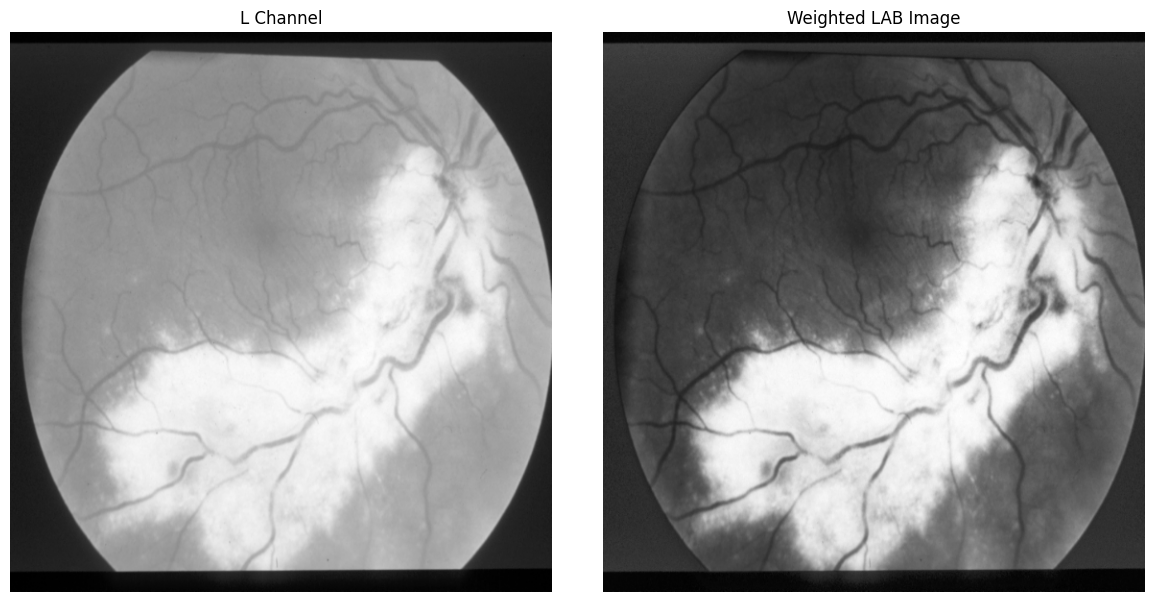

In [14]:
l_channel = lab_image[:, :, 0]
l_channel_normalized = (l_channel - np.min(l_channel)) / (np.max(l_channel) - np.min(l_channel))
gray_image = apply_lab_weights(lab_image, 0.3, -0.3, 0.0)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(l_channel_normalized, cmap='gray')
axs[0].set_title('L Channel')
axs[0].axis('off')
axs[1].imshow(gray_image, cmap='gray')
axs[1].set_title('Weighted LAB Image')
axs[1].axis('off')
plt.tight_layout()
plt.show()

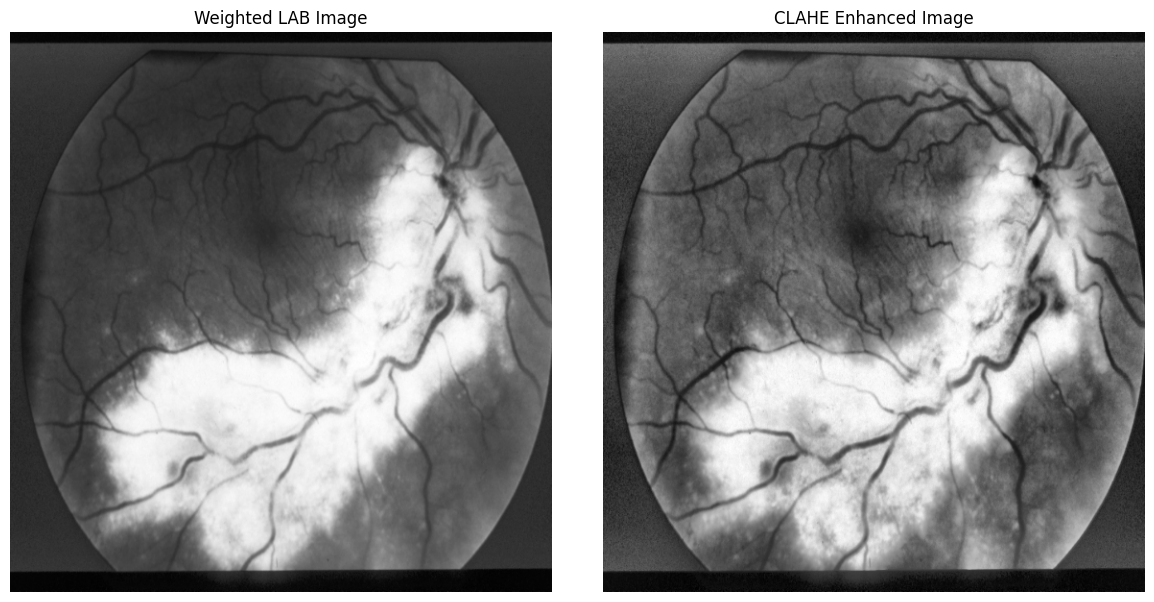

In [15]:
# Apply CLAHE for contrast enhancement
gray_image_uint8 = (gray_image * 255).astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
enhanced_image_uint8 = clahe.apply(gray_image_uint8)
enhanced_image = enhanced_image_uint8.astype(np.float32) / np.max(enhanced_image_uint8)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(gray_image, cmap='gray')
axs[0].set_title('Weighted LAB Image')
axs[0].axis('off')
axs[1].imshow(enhanced_image, cmap='gray')
axs[1].set_title('CLAHE Enhanced Image')
axs[1].axis('off')
plt.tight_layout()
plt.show()

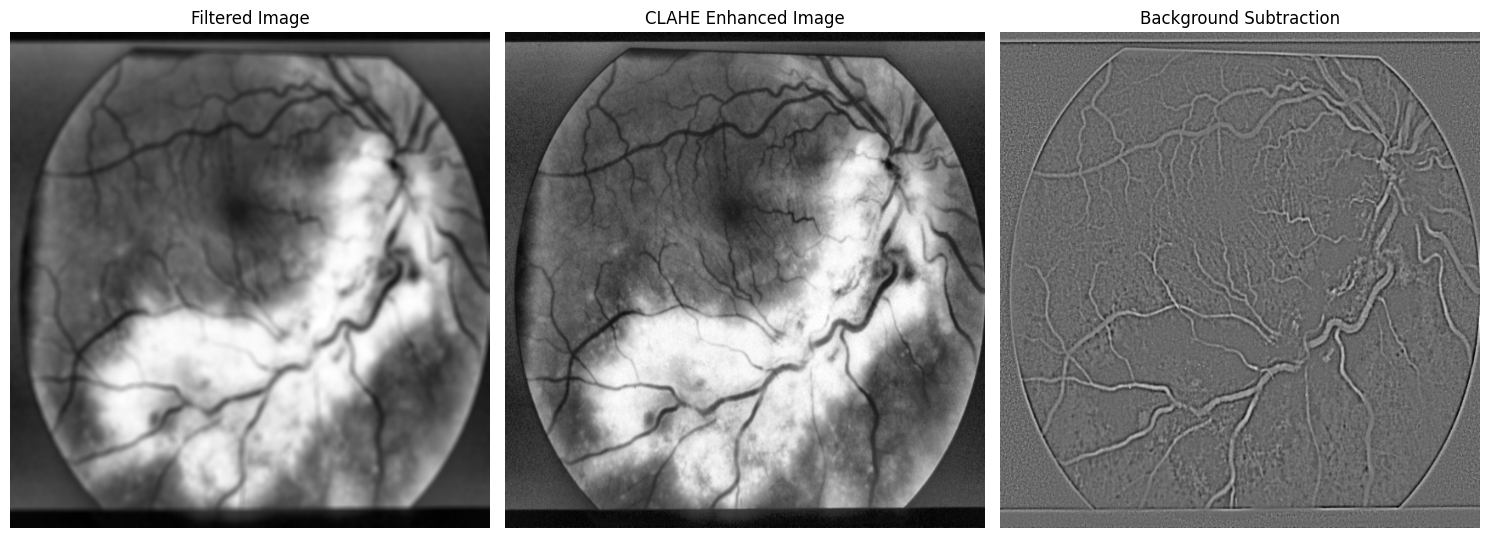

In [16]:
# Apply average filter
kernel_size = 7
kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
filtered_image = cv2.filter2D(enhanced_image, -1, kernel)

# Subtract enhanced from filtered
subtracted_image = filtered_image - enhanced_image

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(filtered_image, cmap='gray')
axs[0].set_title('Filtered Image')
axs[0].axis('off')
axs[1].imshow(enhanced_image, cmap='gray')
axs[1].set_title('CLAHE Enhanced Image')
axs[1].axis('off')
axs[2].imshow(subtracted_image, cmap='gray')
axs[2].set_title('Background Subtraction')
axs[2].axis('off')
plt.tight_layout()
plt.show()

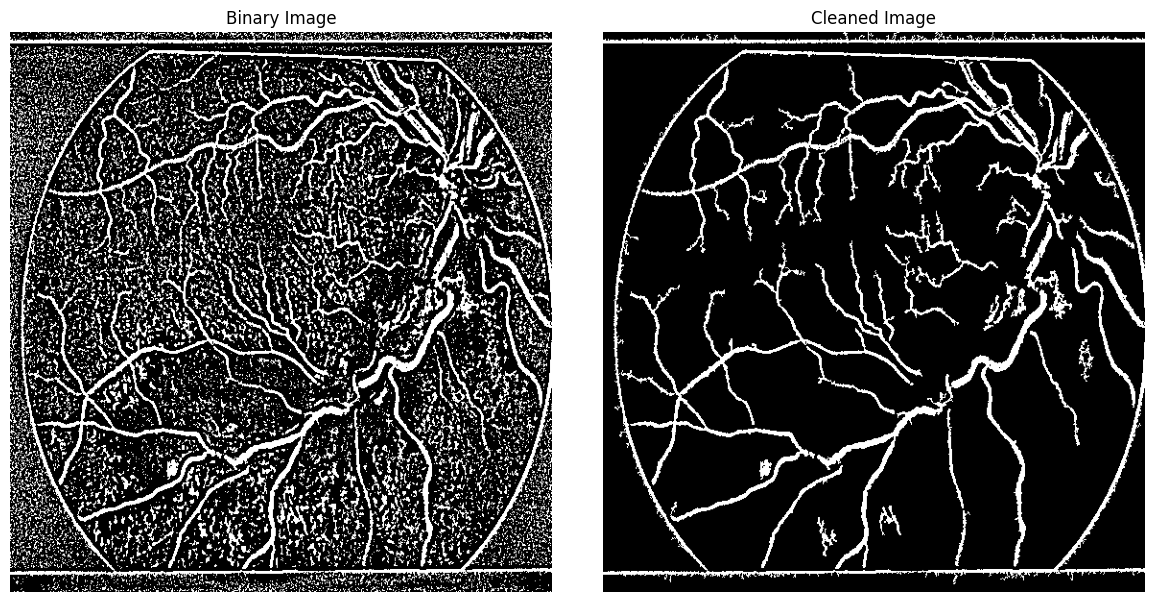

In [17]:
# Apply custom thresholding
level = threshold_level(subtracted_image)
binary_image = (subtracted_image > (level - 0.485121)).astype(np.uint8)

# Remove small objects
clean_image = morphology.remove_small_objects(binary_image.astype(bool), min_size=150, connectivity=200)
clean_image = clean_image.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(binary_image, cmap='gray')
axs[0].set_title('Binary Image')
axs[0].axis('off')
axs[1].imshow(clean_image, cmap='gray')
axs[1].set_title('Cleaned Image')
axs[1].axis('off')
plt.tight_layout()
plt.show()

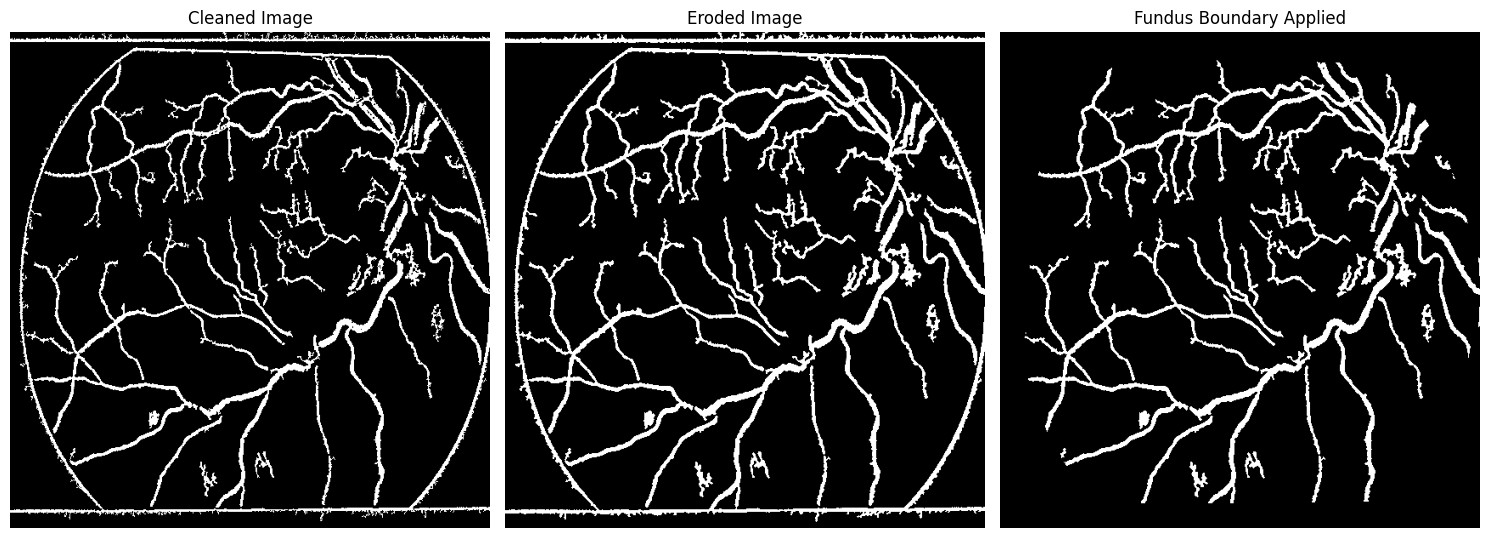

In [18]:
# Fill holes in clean image using dilation followed by erosion
kernel_dial = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
clean_image_dial = cv2.dilate(clean_image, kernel_dial, iterations=1)
kernel_ero = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
clean_image_erode = cv2.erode(clean_image_dial, kernel_ero, iterations=1)

# Apply fundus mask to the result image
masked_erode_image = apply_mask(clean_image_erode, fundus_mask)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(clean_image, cmap='gray')
axs[0].set_title('Cleaned Image')
axs[0].axis('off')
axs[1].imshow(clean_image_erode, cmap='gray')
axs[1].set_title('Eroded Image')
axs[1].axis('off')
axs[2].imshow(masked_erode_image, cmap='gray')
axs[2].set_title('Fundus Boundary Applied')
axs[2].axis('off')
plt.tight_layout()
plt.show()

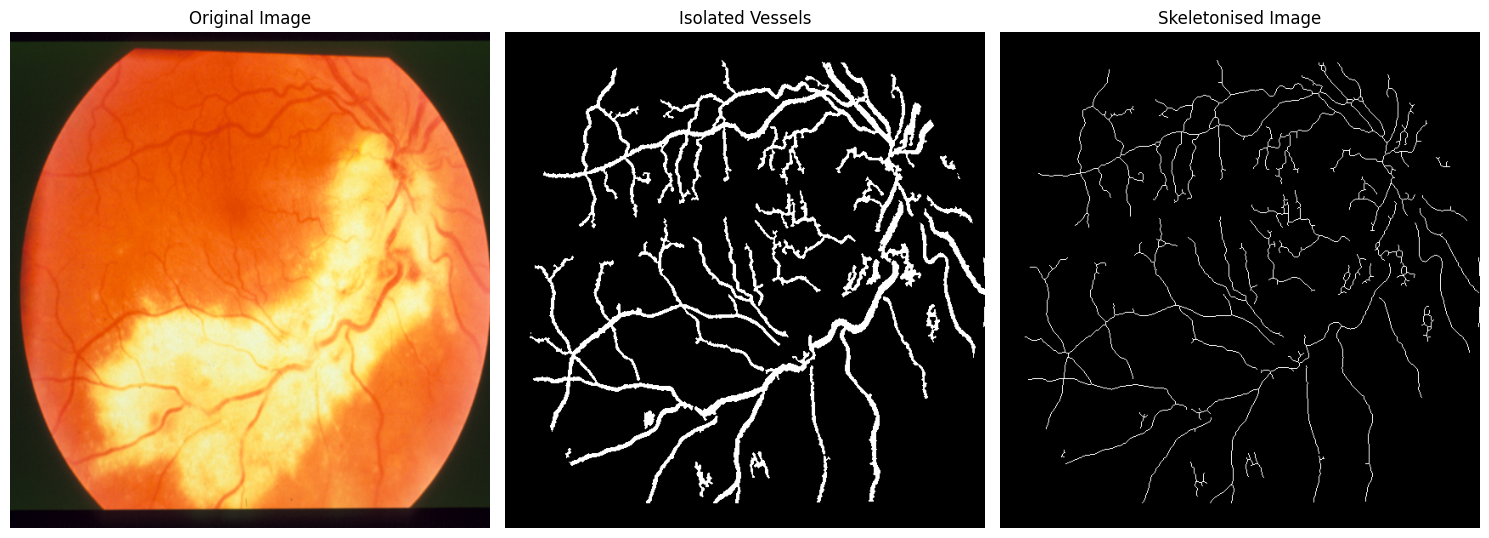

In [19]:
# Skeletonize the image
skeleton_image = morphology.skeletonize(clean_image_erode.astype(bool))

# Apply fundus mask to the skeletonized image
masked_skeleton_image = apply_mask(skeleton_image.astype(np.float32), fundus_mask)

# Display final results
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(converted_image_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(masked_erode_image, cmap='gray')
axs[1].set_title('Isolated Vessels')
axs[1].axis('off')
axs[2].imshow(masked_skeleton_image, cmap='gray')
axs[2].set_title('Skeletonised Image')
axs[2].axis('off')
plt.tight_layout()
plt.show()

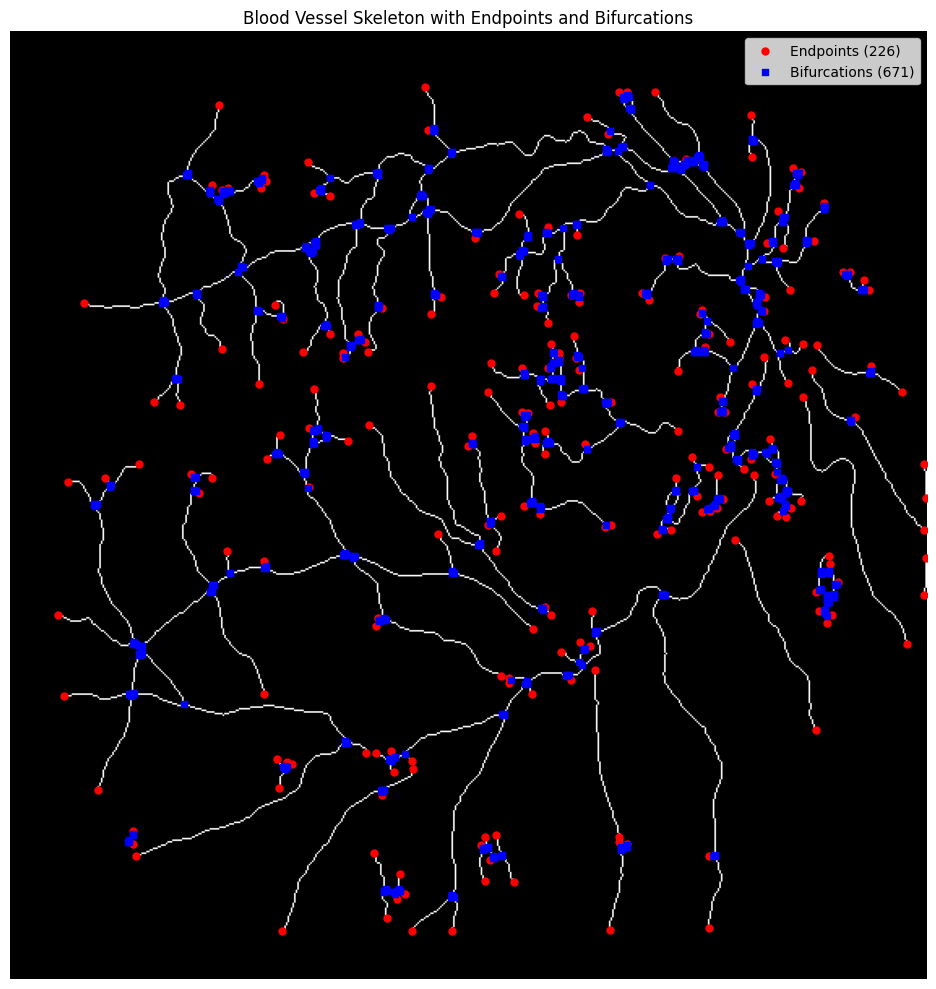

In [20]:
# Apply the graph-based analysis to the skeletonized image
endpoint_coords, bifurcation_coords = graph_based_analysis(masked_skeleton_image)

# Create a visualization with the original skeleton and detected features
fig, ax = plt.subplots(figsize=(12, 10))

# Display the skeleton image in grayscale
ax.imshow(masked_skeleton_image, cmap='gray')

# Plot endpoints in blue
if len(endpoint_coords) > 0:
    ax.scatter(endpoint_coords[:, 1], endpoint_coords[:, 0], c='blue',
               marker='o', s=25, label=f'Endpoints ({len(endpoint_coords)})')

# Plot bifurcations in red
if len(bifurcation_coords) > 0:
    ax.scatter(bifurcation_coords[:, 1], bifurcation_coords[:, 0], c='red',
               marker='s', s=25, label=f'Bifurcations ({len(bifurcation_coords)})')

# Add title and legend
ax.set_title('Blood Vessel Skeleton with Endpoints and Bifurcations')
ax.legend(loc='upper right')
ax.axis('off')

# Calculate some statistics
num_endpoints = len(endpoint_coords)
num_bifurcations = len(bifurcation_coords)
bifurcation_density = num_bifurcations / np.sum(masked_skeleton_image > 0) if np.sum(
    masked_skeleton_image > 0) > 0 else 0

plt.tight_layout()
plt.show()